In [1]:
!nvidia-smi

Tue Oct 14 15:16:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 6000                On  |   00000000:73:00.0  On |                  Off |
| 33%   41C    P5             31W /  260W |     335MiB /  24576MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import pandas as pd

model = AutoModelForCausalLM.from_pretrained("./fine_tuned_model")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_model")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [11]:
def generate_balanced_df(num_samples_per_class=8000, max_new_tokens=50, batch_size=100):
    all_data = []
    label_map = {0: "non-clickbait", 1: "clickbait"}

    for label_id, label_text in label_map.items():
        prompt = f"Label: {label_text}"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        for start in range(0, num_samples_per_class, batch_size):
            n = min(batch_size, num_samples_per_class - start)
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.9,
                top_k=50,
                top_p=0.95,
                num_return_sequences=n
            )

            for o in outputs:
                headline = tokenizer.decode(o, skip_special_tokens=True)
                headline = headline.replace(prompt, "").strip()
                all_data.append({"title": headline, "clickbait": label_id})

    return pd.DataFrame(all_data)

In [12]:
df_synthetic = generate_balanced_df(num_samples_per_class=8000, max_new_tokens=50)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [13]:
df_synthetic.shape

(16000, 2)

In [14]:
df_synthetic.head(50)

,title,clickbait
0,Australian rules football: Warragul to play 20...,0
1,UN calls for action against Sri Lanka,0
2,US Senator Ted Kennedy in 'fortunate' conditio...,0
3,New Zealand opposition group backs same-sex ma...,0
4,G.M. Said to Be Ready to Sell Bonds,0
5,"In an Uncertain Season, G.M. Pays to Cut Its E...",0
6,"With a New Start, Alex Rodriguez Wins His Thir...",0
7,South Africa prepares for presidential debate,0
8,N.B.A.A.A. May Consider Players More Likely to...,0
9,A New Round of New York Jetseseseseseses Takes...,0


In [15]:
print(df_synthetic['clickbait'].value_counts(normalize=True))

clickbait
0    0.5
1    0.5
Name: proportion, dtype: float64


In [16]:
clickbait_df = df_synthetic[df_synthetic['clickbait'] == 1]

In [17]:
clickbait_df.head(50)

,title,clickbait
8000,If You Don't Know Where These Celebrities' Ins...,1
8001,This Is The Worst Thing You'll See In This Vid...,1
8002,21 Times A Woman Made Perfect Perfect Response...,1
8003,17 Of The Best Tweets Of 2015,1
8004,23 Photos Of Your School Friends Who Are Too Cute,1
8005,Can You Guess Which TV Host Was Banned Based O...,1
8006,This Guy Stuck A Little More Than A Boy And No...,1
8007,"17 Things I Learned From ""Harry Potter""",1
8008,"21 Things You Never Knew About ""The Hunger Games""",1
8009,"""Degrassi"" Is The Funniest ""Star Wars"" Poll Yo...",1


In [18]:
df_synthetic.to_csv('synthetic_1.csv', index=False)

In [2]:
#!pip install wordcloud

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("clickbait_title_classification.csv")

In [6]:
df_s = pd.read_csv("synthetic_1.csv")

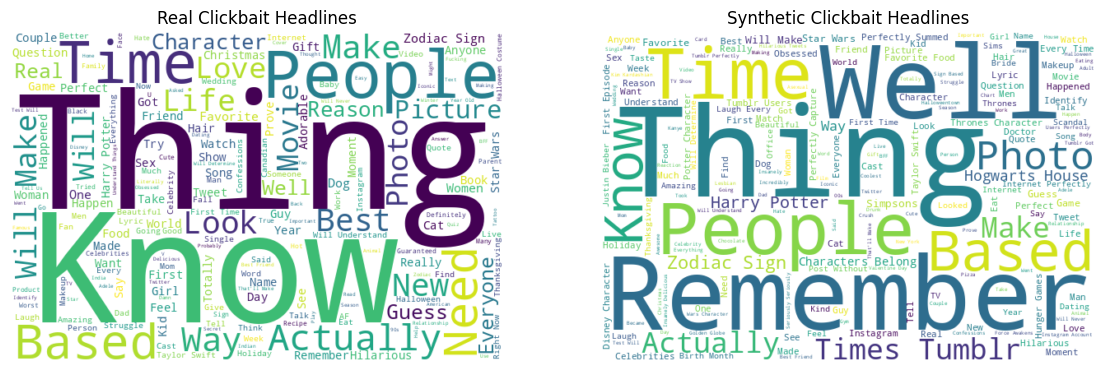

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract clickbait-only headlines
real_clickbait = df[df['clickbait'] == 1]['title'].tolist()
syn_clickbait  = df_s[df_s['clickbait'] == 1]['title'].tolist()

# Convert to long text
real_text = " ".join(real_clickbait)
syn_text  = " ".join(syn_clickbait)

# Generate word clouds
wc_real = WordCloud(width=600, height=400, background_color="white").generate(real_text)
wc_syn  = WordCloud(width=600, height=400, background_color="white").generate(syn_text)

# Plot side by side
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.imshow(wc_real, interpolation="bilinear")
plt.title("Real Clickbait Headlines")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc_syn, interpolation="bilinear")
plt.title("Synthetic Clickbait Headlines")
plt.axis("off")

plt.show()